In [1]:
import pandas as pd
import os
from functools import reduce

In [2]:
folder_path = '/Users/ariana/Desktop/DSITW - Final Project/Data Tables'

investments_path = os.path.join(folder_path, 'investments.csv')
objects_path = os.path.join(folder_path, 'objects.csv')
people_path = os.path.join(folder_path, 'people.csv')
funding_rounds_path = os.path.join(folder_path, 'funding_rounds.csv')
milestones_path = os.path.join(folder_path, 'milestones.csv')

In [3]:
data_frames = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv') and filename != 'objects.csv':  # Exclude objects.csv
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        data_frames.append(df)
#data_frames

### Defining a "good" match:

1. Alignment with Investor's Preferences: This could include the investor's historical investment patterns, preferred sectors, typical investment stages (seed, Series A, etc.), geographical preferences, and the size of investments they typically make.

2. Startup's Potential for Success: This could be indicated by factors such as the startup's sector, growth rate, stage of development, the track record of its founders and team (education, past successes), and its funding history (amount raised, valuation growth, etc.).

A 'good' match would be a startup that aligns well with an investor's preferences and shows promising indicators of future success.

### Data Collection and Integration Plan:

To build a dataset that will allow us to match investors with startups, we need to integrate data from several tables. Below are the steps to achieve this:

- Investments Data (investments.csv):

1. Identify investors and the startups they have invested in.
2. Extract features such as the number of investments, average investment amount, sectors invested in, and stages of investment.

- Objects Data (objects.csv):

1. Contains details on both people and companies.
2. For companies: Extract startup sector, stage, location, and funding history.
3. For people: Extract professional backgrounds, which could be used to infer the quality of the startup team.

- People Data (people.csv):

1. Obtain information about individuals, which can be used to create features around the founders' and key personnel's experience and track records.

- Funding Rounds Data (funding_rounds.csv):

1. Gather information on the funding rounds of startups, such as the amount raised, the date of funding, and the funding stage.

- Milestones Data (milestones.csv):

1. Collect data on significant achievements by startups, which could indicate their growth and potential for success.

### Loading the data

In [4]:
investments_df = pd.read_csv(investments_path)
objects_df = pd.read_csv(objects_path)
people_df = pd.read_csv(people_path)
funding_rounds_df = pd.read_csv(funding_rounds_path)
milestones_df = pd.read_csv(milestones_path)

/var/folders/2s/p1k4247d415_4x20kdhsxn8h0000gn/T/ipykernel_27415/2764848474.py:2: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects_df = pd.read_csv(objects_path)


In [5]:
investments_df.head()

,id,funding_round_id,funded_object_id,investor_object_id,created_at,updated_at
0,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29
1,2,1,c:4,f:2,2007-07-04 04:52:57,2008-02-27 23:14:29
2,3,3,c:5,f:4,2007-05-27 06:09:10,2013-06-28 20:07:23
3,4,4,c:5,f:1,2007-05-27 06:09:36,2013-06-28 20:07:24
4,5,4,c:5,f:5,2007-05-27 06:09:36,2013-06-28 20:07:24


In [7]:
objects_df.head()

,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,...,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,...,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,...,NaN,0,0.0,NaN,NaN,0,6,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,...,NaN,0,0.0,2003-02-01,2011-09-23,4,12,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 17:10:34,2008-09-06 14:19:18


### Merging dataframes

In [8]:
# Merge investments with objects to get detailed information about startups
investments_extended_df = investments_df.merge(
    objects_df, 
    left_on='funded_object_id', 
    right_on='id', 
    how='left',
    suffixes=('', '_object')  # Suffix for the columns from objects_df
)

# Merge the extended investments dataframe with people to get investor details
investments_people_df = investments_extended_df.merge(
    people_df, 
    left_on='investor_object_id', 
    right_on='object_id', 
    how='left',
    suffixes=('', '_people')  # Suffix for the columns from people_df
)

# Merge funding rounds to add information about each funding event
full_investment_df = investments_people_df.merge(
    funding_rounds_df, 
    left_on='funded_object_id', 
    right_on='object_id', 
    how='left',
    suffixes=('_investments_people', '_funding_rounds')  # Adjust suffixes accordingly
)

# Merge milestones to add startup success indicators
full_startup_df = full_investment_df.merge(
    milestones_df, 
    left_on='funded_object_id', 
    right_on='object_id', 
    how='left',
    suffixes=('_full_investment', '_milestones')  # Adjust suffixes accordingly
)

full_startup_df.head()

,id_investments_people,funding_round_id_investments_people,funded_object_id,investor_object_id,created_at_investments_people,updated_at_investments_people,id_object,entity_type,entity_id,parent_id,...,updated_at_funding_rounds,id,object_id,milestone_at,milestone_code,description_milestones,source_url_milestones,source_description_milestones,created_at,updated_at
0,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,c:4,Company,4.0,NaN,...,2008-02-27 23:14:29,8092.0,c:4,2010-10-25,other,Another Digg Exec Is Out: Longtime CFO John Mo...,http://techcrunch.com/2010/10/25/another-digg-...,Another Digg Exec Is Out: Longtime CFO John Mo...,2010-10-27 11:25:39,2010-10-27 11:25:39
1,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,c:4,Company,4.0,NaN,...,2008-02-27 23:14:29,21587.0,c:4,2012-07-13,other,Digg Sold To LinkedIn AND The Washington Post ...,http://techcrunch.com/2012/07/12/digg-sold-to-...,Digg Sold To LinkedIn AND The Washington Post ...,2012-07-14 01:49:16,2012-07-14 01:49:16
2,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,c:4,Company,4.0,NaN,...,2008-02-27 23:14:29,37600.0,c:4,2013-11-05,other,Digg Video launches.,http://techcrunch.com/2013/11/05/digg-gives-vi...,Digg Gives Videos Prime Placement With New Dig...,2013-11-05 21:35:47,2013-11-05 21:35:47
3,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,c:4,Company,4.0,NaN,...,2008-02-27 23:14:29,8092.0,c:4,2010-10-25,other,Another Digg Exec Is Out: Longtime CFO John Mo...,http://techcrunch.com/2010/10/25/another-digg-...,Another Digg Exec Is Out: Longtime CFO John Mo...,2010-10-27 11:25:39,2010-10-27 11:25:39
4,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,c:4,Company,4.0,NaN,...,2008-02-27 23:14:29,21587.0,c:4,2012-07-13,other,Digg Sold To LinkedIn AND The Washington Post ...,http://techcrunch.com/2012/07/12/digg-sold-to-...,Digg Sold To LinkedIn AND The Washington Post ...,2012-07-14 01:49:16,2012-07-14 01:49:16


### Handling Missing Values

Depending on the context, there are several strategies to handle missing values:

1. Drop missing values: If the dataset is large and the number of missing values is relatively small, you can simply drop the rows or columns with missing data.
2. Impute missing values: For numerical features, you can impute missing values with a measure of central tendency (mean, median, or mode). For categorical features, the mode is commonly used.

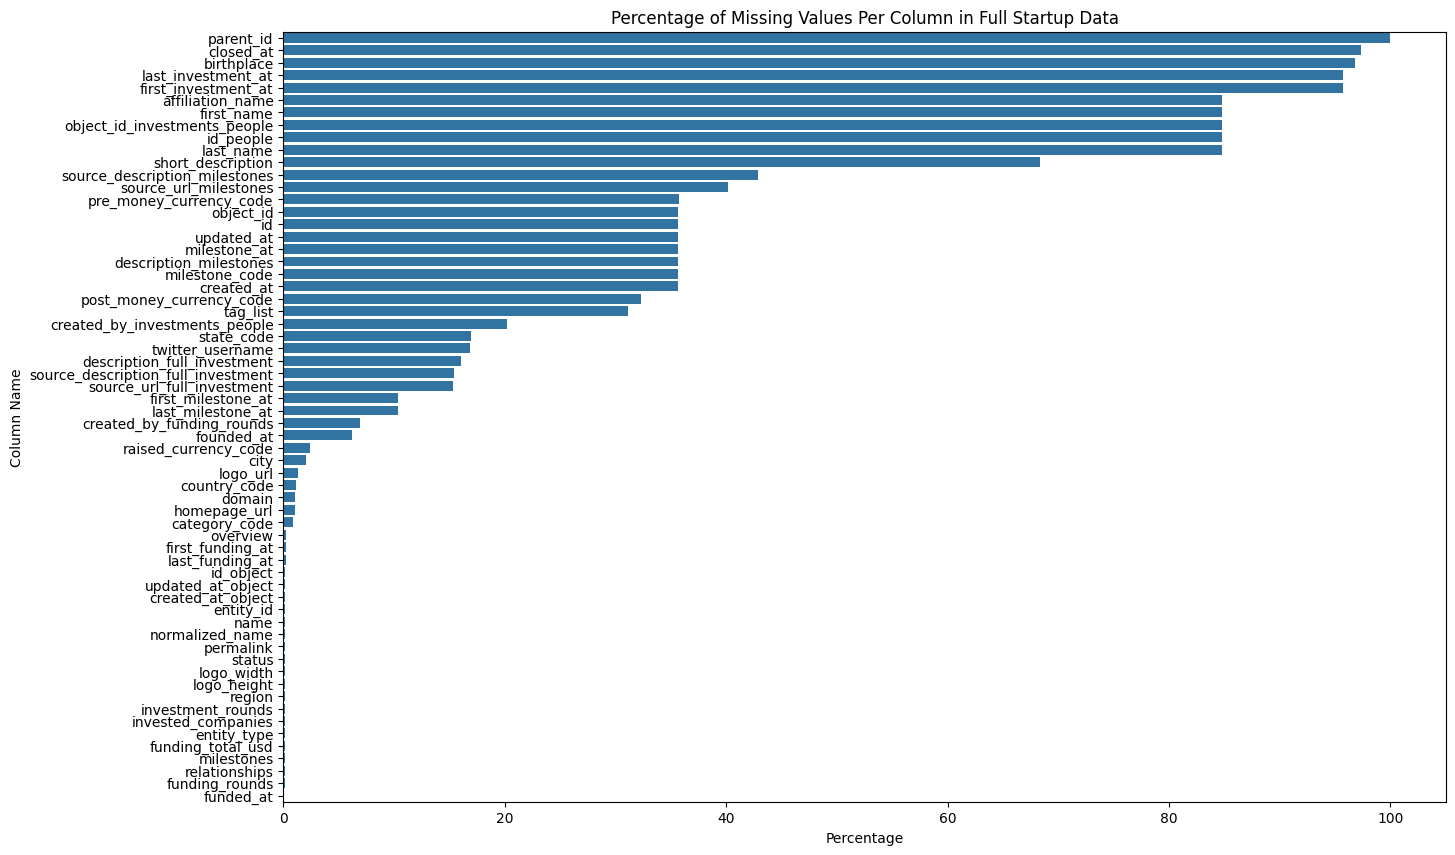

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage of missing values for each column
missing_values = full_startup_df.isnull().mean() * 100

# Filter out columns that have no missing values to reduce clutter in the visualization
missing_values = missing_values[missing_values > 0]

# Sort the columns based on the percentage of missing values
missing_values.sort_values(ascending=False, inplace=True)

# Plot the results
plt.figure(figsize=(15, 10))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title('Percentage of Missing Values Per Column in Full Startup Data')
plt.xlabel('Percentage')
plt.ylabel('Column Name')

# Show the plot
plt.show()

In [10]:
# Calculate the count of missing values for each column
missing_values_count = full_startup_df.isnull().sum()

# Sort the columns based on the count of missing values
missing_values_count_sorted = missing_values_count.sort_values(ascending=False)

missing_values_count_sorted

parent_id                          407396
closed_at                          396572
birthplace                         394298
last_investment_at                 389878
first_investment_at                389878
                                    ...  
funding_round_type                      0
object_id_funding_rounds                0
funding_round_id_funding_rounds         0
id_funding_rounds                       0
id_investments_people                   0
Length: 84, dtype: int64

In [11]:
# Output all the column names from the full_startup_df DataFrame
all_columns = full_startup_df.columns.tolist()
all_columns

['id_investments_people',
 'funding_round_id_investments_people',
 'funded_object_id',
 'investor_object_id',
 'created_at_investments_people',
 'updated_at_investments_people',
 'id_object',
 'entity_type',
 'entity_id',
 'parent_id',
 'name',
 'normalized_name',
 'permalink',
 'category_code',
 'status',
 'founded_at',
 'closed_at',
 'domain',
 'homepage_url',
 'twitter_username',
 'logo_url',
 'logo_width',
 'logo_height',
 'short_description',
 'description_full_investment',
 'overview',
 'tag_list',
 'country_code',
 'state_code',
 'city',
 'region',
 'first_investment_at',
 'last_investment_at',
 'investment_rounds',
 'invested_companies',
 'first_funding_at',
 'last_funding_at',
 'funding_rounds',
 'funding_total_usd',
 'first_milestone_at',
 'last_milestone_at',
 'milestones',
 'relationships',
 'created_by_investments_people',
 'created_at_object',
 'updated_at_object',
 'id_people',
 'object_id_investments_people',
 'first_name',
 'last_name',
 'birthplace',
 'affiliation_nam

In [12]:
# List of columns to drop that may be irrelevant for the recommendation system
columns_to_drop = [
    'id_investments_people', 'id_object', 'id_people', 'id_funding_rounds',
    'created_at_investments_people', 'updated_at_investments_people', 'created_at_object',
    'updated_at_object', 'created_by_investments_people', 'created_at_funding_rounds', 
    'updated_at_funding_rounds', 'entity_type', 'entity_id', 'parent_id', 'permalink', 
    'domain', 'homepage_url', 'twitter_username', 'logo_url', 'logo_width', 'logo_height', 'created_by_funding_rounds',
    'source_url_full_investment', 'source_url_milestones', 'affiliation_name', 'source_description_full_investment',
    'source_description_milestones', 'closed_at', 'birthplace', 'normalized_name', 'short_description',
    'object_id_investments_people', 'object_id_funding_rounds', 'object_id',
    'funding_round_id_investments_people', 'funding_round_id_funding_rounds',
    'raised_currency_code', 'pre_money_currency_code', 'post_money_currency_code',
    'created_at', 'updated_at', 'pre_money_valuation', 'post_money_valuation',     
    'first_investment_at', 'description_milestones', 'milestone_code', 'milestone_at',
    'last_investment_at', 'id', 'tag_list', 'relationships',
    'first_name',
    'last_name'
]

# Drop the columns from the DataFrame
full_startup_df = full_startup_df.drop(columns=columns_to_drop, errors='ignore')

# Set option to display all columns
pd.set_option('display.max_columns', None)
full_startup_df.head() 

,funded_object_id,investor_object_id,name,category_code,status,founded_at,description_full_investment,overview,country_code,state_code,city,region,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round
0,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
1,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
2,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
3,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1
4,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1


In [13]:
# Calculate the count of missing values for each column in the updated DataFrame
missing_values_count_updated = full_startup_df.isnull().sum()

# Sort the columns based on the count of missing values
missing_values_count_sorted_updated = missing_values_count_updated.sort_values(ascending=False)

missing_values_count_sorted_updated

state_code                     69124
description_full_investment    65488
last_milestone_at              42259
first_milestone_at             42259
founded_at                     25142
city                            8441
country_code                    4726
category_code                   3726
overview                        1059
last_funding_at                  848
first_funding_at                 848
milestones                       759
funding_total_usd                759
funding_rounds                   759
investment_rounds                759
invested_companies               759
region                           759
status                           759
name                             759
funded_at                        237
is_first_round                     0
raised_amount                      0
participants                       0
post_money_valuation_usd           0
pre_money_valuation_usd            0
funded_object_id                   0
raised_amount_usd                  0
f

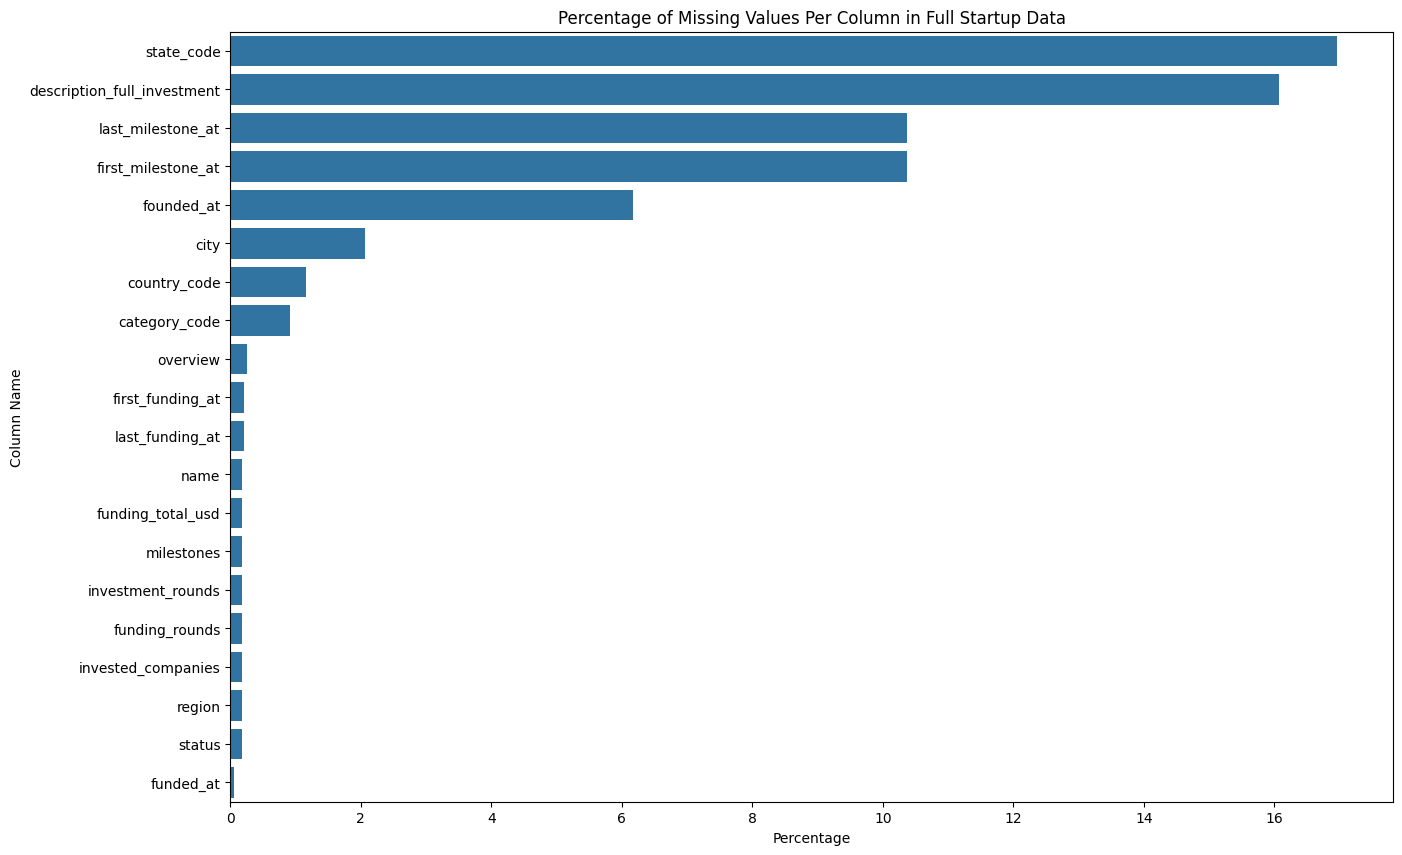

In [14]:
# Perform EDA for missing values in full_startup_df DataFrame

# Calculate the percentage of missing values for each column
missing_values = full_startup_df.isnull().mean() * 100

# Filter out columns that have no missing values to reduce clutter in the visualization
missing_values = missing_values[missing_values > 0]

# Sort the columns based on the percentage of missing values
missing_values.sort_values(ascending=False, inplace=True)

# Plot the results
plt.figure(figsize=(15, 10))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title('Percentage of Missing Values Per Column in Full Startup Data')
plt.xlabel('Percentage')
plt.ylabel('Column Name')

# Show the plot
plt.show()

In [15]:
missing_state_code_df = full_startup_df[full_startup_df['state_code'].isna()]
missing_state_code_df

,funded_object_id,investor_object_id,name,category_code,status,founded_at,description_full_investment,overview,country_code,state_code,city,region,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round
2515,c:65,f:52,blogTV,games_video,acquired,2006-05-01,NaN,"""Hello, blogTV is here! This is the place wher...",ISR,NaN,Ramat Gan,Ramat Gan,0.0,0.0,2007-01-01,2007-01-01,1.0,3000000.0,2008-04-17,2012-09-28,4.0,2007-01-01,series-a,seed,3000000.0,3000000.0,0.0,0.0,1,1,1
2591,c:83,f:18,AllPeers,web,closed,2004-08-01,NaN,"AllPeers is a simple, persistent buddy list in...",GBR,NaN,Oxford,London,0.0,0.0,2006-03-01,2006-03-01,1.0,0.0,2008-04-07,2012-06-15,3.0,2006-03-01,series-a,a,0.0,0.0,0.0,0.0,2,1,1
2592,c:83,f:30,AllPeers,web,closed,2004-08-01,NaN,"AllPeers is a simple, persistent buddy list in...",GBR,NaN,Oxford,London,0.0,0.0,2006-03-01,2006-03-01,1.0,0.0,2008-04-07,2012-06-15,3.0,2006-03-01,series-a,a,0.0,0.0,0.0,0.0,2,1,1
2754,c:62,f:26,Skype,software,acquired,2003-08-01,VoIP Software,Skype is a software application that allows us...,LUX,NaN,Luxembourg City,Luxembourg City,3.0,3.0,2002-01-01,2010-04-16,5.0,76805032.0,2010-08-16,2013-12-06,6.0,2004-03-01,series-b,b,18800000.0,18800000.0,0.0,0.0,2,0,0
2755,c:62,f:26,Skype,software,acquired,2003-08-01,VoIP Software,Skype is a software application that allows us...,LUX,NaN,Luxembourg City,Luxembourg City,3.0,3.0,2002-01-01,2010-04-16,5.0,76805032.0,2010-08-16,2013-12-06,6.0,2004-03-01,series-b,b,18800000.0,18800000.0,0.0,0.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407388,c:285244,p:267312,The New Motion,cleantech,operating,2009-09-03,Electric Mobility Service Provider,The New Motion offers advanced charging soluti...,NLD,NaN,Amsterdam,Amsterdam,0.0,0.0,2009-01-01,2013-01-01,4.0,0.0,2013-06-01,2013-06-01,1.0,2013-01-01,series-c+,c,0.0,8500000.0,0.0,0.0,6,1,0
407389,c:285244,p:267312,The New Motion,cleantech,operating,2009-09-03,Electric Mobility Service Provider,The New Motion offers advanced charging soluti...,NLD,NaN,Amsterdam,Amsterdam,0.0,0.0,2009-01-01,2013-01-01,4.0,0.0,2013-06-01,2013-06-01,1.0,2012-01-01,series-b,b,0.0,3100000.0,0.0,0.0,5,0,0
407390,c:285244,p:267312,The New Motion,cleantech,operating,2009-09-03,Electric Mobility Service Provider,The New Motion offers advanced charging soluti...,NLD,NaN,Amsterdam,Amsterdam,0.0,0.0,2009-01-01,2013-01-01,4.0,0.0,2013-06-01,2013-06-01,1.0,2011-01-01,series-a,a,0.0,1615000.0,0.0,0.0,3,0,0
407391,c:285244,p:267312,The New Motion,cleantech,operating,2009-09-03,Electric Mobility Service Provider,The New Motion offers advanced charging soluti...,NLD,NaN,Amsterdam,Amsterdam,0.0,0.0,2009-01-01,2013-01-01,4.0,0.0,2013-06-01,2013-06-01,1.0,2009-01-01,angel,angel,0.0,350000.0,0.0,0.0,3,0,1


In [16]:
# Impute missing values for specified columns with 'Unknown'
columns_to_impute_unknown = [
    'state_code', 'last_milestone_at', 'first_milestone_at',
    'founded_at', 'city', 'country_code', 'category_code', 'first_funding_at', 'last_funding_at', 'name',
    'funding_total_usd', 'fonding_at'
]

for col in columns_to_impute_unknown:
    # Check if the column exists before imputing to avoid KeyErrors
    if col in full_startup_df.columns:
        full_startup_df[col].fillna('Unknown', inplace=True)
    else:
        print(f"Column {col} not found in DataFrame.")

# Display the first few rows to confirm imputation
full_startup_df.head()

Column fonding_at not found in DataFrame.


/var/folders/2s/p1k4247d415_4x20kdhsxn8h0000gn/T/ipykernel_27415/973694402.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_startup_df[col].fillna('Unknown', inplace=True)


,funded_object_id,investor_object_id,name,category_code,status,founded_at,description_full_investment,overview,country_code,state_code,city,region,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round
0,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
1,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
2,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
3,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1
4,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1


In [17]:
full_startup_df.head()

,funded_object_id,investor_object_id,name,category_code,status,founded_at,description_full_investment,overview,country_code,state_code,city,region,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round
0,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
1,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
2,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
3,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1
4,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1


### Handling Duplicates



In [18]:
# Identify duplicate rows (except for the first occurrence)
duplicate_rows = full_startup_df[full_startup_df.duplicated(keep='first')]

# Display the head of the duplicate rows
duplicate_rows.head()

,funded_object_id,investor_object_id,name,category_code,status,founded_at,description_full_investment,overview,country_code,state_code,city,region,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round
1,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
2,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0
4,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1
5,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1
7,c:4,f:1,Digg,news,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2008-09-24,series-c+,c,28700000.0,28700000.0,0.0,0.0,4,0,0


In [19]:
# Count duplicates in the DataFrame
duplicate_count = full_startup_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 252802


In [20]:
# Drop duplicates from the DataFrame
full_startup_df = full_startup_df.drop_duplicates()

# Check the new shape of the DataFrame to confirm duplicates have been removed
print(full_startup_df.shape)

(154594, 31)


### Dropping Rows where multiple useful columns are "unknown" or "nan"

In [21]:
import numpy as np

# Define the critical columns for which "Unknown" or NaN values make a row not useful
critical_columns = [
    'funded_object_id', 'investor_object_id', 'name', 'category_code',
    'funding_round_type', 'raised_amount_usd', 'funding_total_usd', 'status'
]

# First, replace "Unknown" with NaN for uniformity in handling missing values
full_startup_df.replace("Unknown", np.nan, inplace=True)

# Drop rows where any of the critical columns have NaN values
full_startup_df = full_startup_df.dropna(subset=critical_columns)

# Display the shape of the DataFrame after dropping rows
full_startup_df.shape


(151828, 31)

### Identifying Outliers

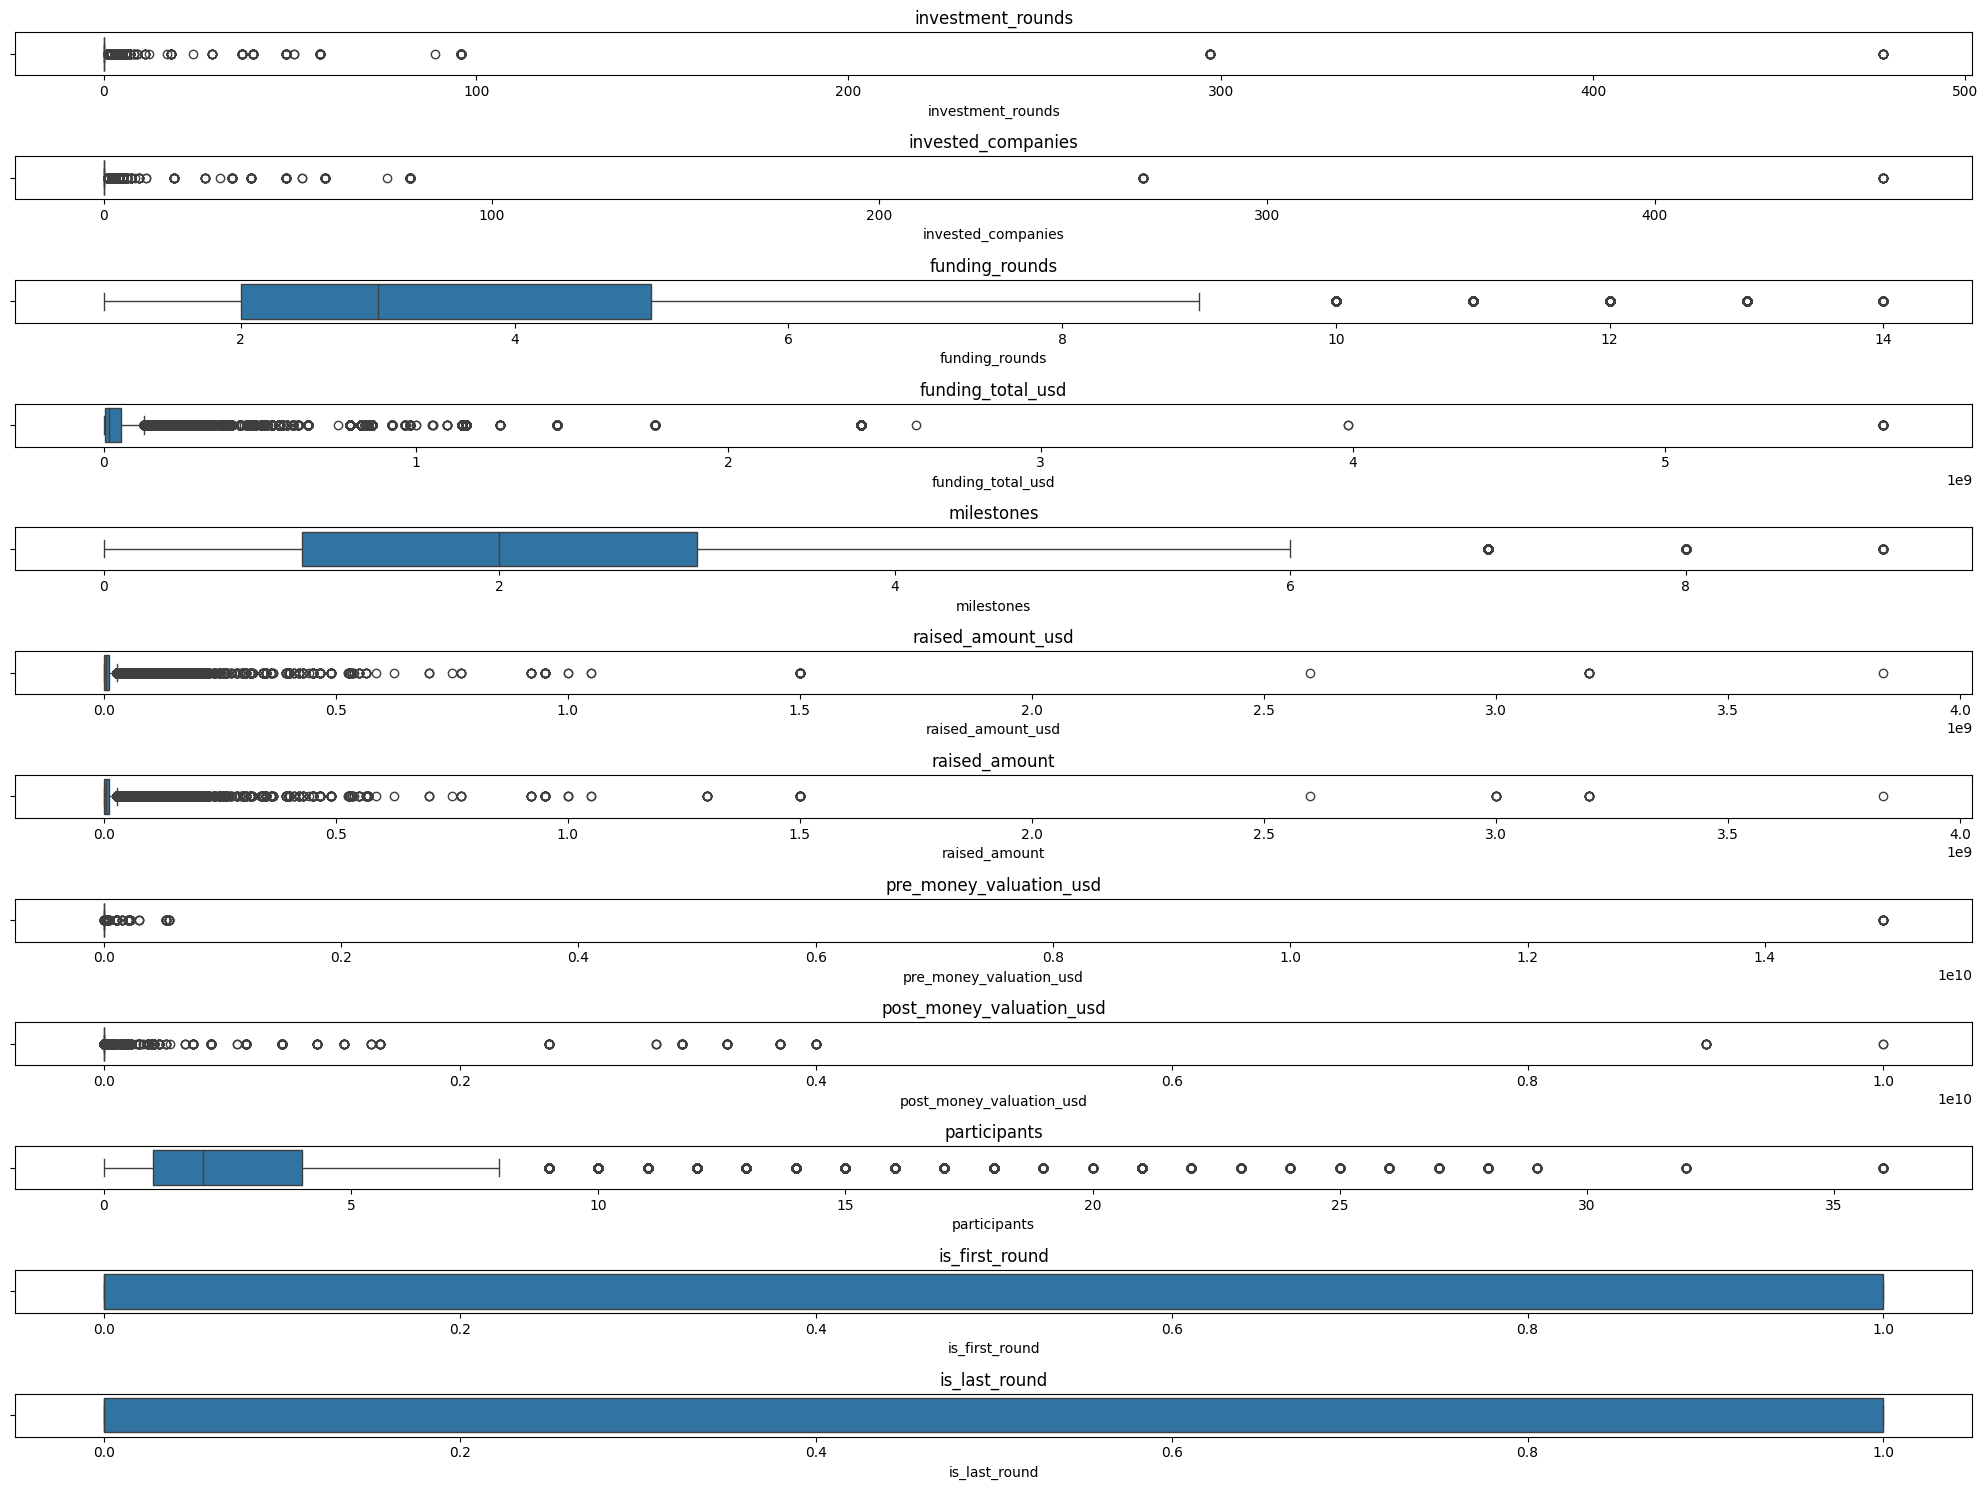

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'cleaned_df' is your DataFrame after cleaning
numerical_cols = full_startup_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Plotting box plots for each numerical column
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(x=full_startup_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### Feature Engineering

### Startups

1. Industry Sector:
- category_code: You already have this as a categorical feature. Consider one-hot encoding this column to create binary features for each industry sector.

2. Growth Rate:

- You can calculate the growth rate based on funding_total_usd over time. This might involve creating a feature that represents the change in funding over different rounds or the time between the first_funding_at and last_funding_at.

3. Founder Experience:

- This could be inferred from the overview or relationships if you have information about the founders' previous companies or roles. Text analysis or manual tagging might be needed.

#### Industry Sector - One-Hot Encoding

In [23]:
# One-hot encoding 'category_code'
full_startup_df = pd.get_dummies(full_startup_df, columns=['category_code'], prefix='sector')

# Display the first few rows to confirm the new binary columns
full_startup_df.head()


,funded_object_id,investor_object_id,name,status,founded_at,description_full_investment,overview,country_code,state_code,city,region,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,sector_advertising,sector_analytics,sector_automotive,sector_biotech,sector_cleantech,sector_consulting,sector_design,sector_ecommerce,sector_education,sector_enterprise,sector_fashion,sector_finance,sector_games_video,sector_government,sector_hardware,sector_health,sector_hospitality,sector_legal,sector_local,sector_manufacturing,sector_medical,sector_messaging,sector_mobile,sector_music,sector_nanotech,sector_network_hosting,sector_news,sector_nonprofit,sector_other,sector_pets,sector_photo_video,sector_public_relations,sector_real_estate,sector_search,sector_security,sector_semiconductor,sector_social,sector_software,sector_sports,sector_transportation,sector_travel,sector_web
0,c:4,f:1,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,c:4,f:1,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,c:4,f:1,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2008-09-24,series-c+,c,28700000.0,28700000.0,0.0,0.0,4,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,c:4,f:1,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2011-07-12,series-c+,d,5000000.0,5000000.0,0.0,0.0,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,c:4,f:2,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


#### NLP on Overview

In [24]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

full_startup_df = full_startup_df.dropna(subset=['overview'])

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(full_startup_df['overview'])

# Initialize the LDA Model
number_of_topics = 5  # This is an arbitrary choice and should be tuned
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
lda_topics = lda.fit_transform(tfidf_matrix)

# Sentiment Analysis using TextBlob
sentiment_scores = full_startup_df['overview'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Add the sentiment scores to the dataframe
full_startup_df['sentiment_score'] = sentiment_scores

# Add LDA topics to the dataframe
lda_feature_names = [f'topic_{i}' for i in range(number_of_topics)]
lda_df = pd.DataFrame(lda_topics, columns=lda_feature_names)
full_startup_df = pd.concat([full_startup_df.reset_index(drop=True), lda_df.reset_index(drop=True)], axis=1)

In [27]:
full_startup_df.head()

,funded_object_id,investor_object_id,name,status,founded_at,description_full_investment,overview,country_code,state_code,city,region,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,sector_advertising,sector_analytics,sector_automotive,sector_biotech,sector_cleantech,sector_consulting,sector_design,sector_ecommerce,sector_education,sector_enterprise,sector_fashion,sector_finance,sector_games_video,sector_government,sector_hardware,sector_health,sector_hospitality,sector_legal,sector_local,sector_manufacturing,sector_medical,sector_messaging,sector_mobile,sector_music,sector_nanotech,sector_network_hosting,sector_news,sector_nonprofit,sector_other,sector_pets,sector_photo_video,sector_public_relations,sector_real_estate,sector_search,sector_security,sector_semiconductor,sector_social,sector_software,sector_sports,sector_transportation,sector_travel,sector_web,sentiment_score,topic_0,topic_1,topic_2,topic_3,topic_4
0,c:4,f:1,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.279167,0.024052,0.023746,0.023775,0.02387,0.904557
1,c:4,f:1,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2005-10-01,series-a,a,2800000.0,2800000.0,0.0,0.0,8,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.279167,0.024052,0.023746,0.023775,0.02387,0.904557
2,c:4,f:1,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2008-09-24,series-c+,c,28700000.0,28700000.0,0.0,0.0,4,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.279167,0.024052,0.023746,0.023775,0.02387,0.904557
3,c:4,f:1,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2011-07-12,series-c+,d,5000000.0,5000000.0,0.0,0.0,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.279167,0.024052,0.023746,0.023775,0.02387,0.904557
4,c:4,f:2,Digg,acquired,2004-10-11,user driven social content website,Digg is a user driven social content website. ...,USA,CA,San Francisco,SF Bay,0.0,0.0,2005-10-01,2011-07-12,4.0,45000000.0,2010-01-08,2013-12-04,8.0,2006-12-01,series-b,b,8500000.0,8500000.0,0.0,0.0,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,Fa